# Sheridan Kamal

## DATA 71200 - Project 1 (Due 3/25/2020, 11:59p)

### Project
For my project, I wish to use data and machine learning methods to predict recessions. In this portion of the project, I will be creating a dataset from a list of features (some of which are transformed) and then split the dataset into training and testing sets. The training and testing sets will be used in the later portions of my project in which I will be creating and running various machine learning models for my predictions.

### Data
Since the features I needed for my dataset were not conveniently included in a downloadable dataset, I had to download each feature seperately and combine them together into one dataframe. I was able to pull each economic feature seperately from FRED (Federal Reserve Economic Data from the Federal Reserve Bank of St. Louis) using Quandl, which also had the added bonus of automatically calculating selected transformations if I chose to do so, and the financial feature was downloadable from Yahoo! Finance so I downloaded the dataset and created the transformed variables in Excel and imported the dataset as a CSV. I created Recession labels from a list of start and end dates. I then concated each feature and the labels using an inner join to create one dataframe. After creating a correlation heatmap, I selected the features I wanted to include in my final dataset (each of the features fall under a certain category; employment, monetary policy, inflation, bond market, or stock market). I then saved this dataset as a CSV and performed some descriptive statistics on the data. Next, I created a histogram for each feature and a scatter matrix for the features. Finally, I created training and testing sets using TimeSeriesSplit with 5 splits.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import quandl as qnd
#import yfinance as yf

tbond_10yr = qnd.get('FRED/GS10')
tbond_10yr_pchange = qnd.get('FRED/GS10', transformation = "rdiff") #Percent change transformation
spread_2yr = qnd.get('FRED/T10Y2YM')
#spread_3yr = qnd.get('FRED/T10Y3MM')
fedrate = qnd.get('FRED/FEDFUNDS')
fedrate_pchange = qnd.get('FRED/FEDFUNDS', transformation = "rdiff") #Percent change transformation
nonfarm_payrolls = qnd.get('FRED/PAYEMS')
nonfarm_payrolls_pchange = qnd.get('FRED/PAYEMS', transformation = "rdiff") #Percent change transformation
cpi = qnd.get('FRED/CPIAUCSL')
cpi_pchange = qnd.get('FRED/CPIAUCSL', transformation = "rdiff") #Percent change transformation
#recession_dates = qnd.get('FRED/JHDUSRGDPBR')
#snp500 = yf.download('^GSPC', auto_adjust = True, treads = True)
snp_500 = pd.read_csv('S&P 500 Index.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date') #Four columns of percent change transformations
recessions = {'1': {'Begin': '1957-08-01', 'End': '1958-04-01'}, 
              '2': {'Begin': '1960-04-01', 'End': '1961-02-01'}, 
              '3': {'Begin': '1969-12-01', 'End': '1970-11-01'}, 
              '4': {'Begin': '1973-11-01', 'End': '1975-03-01'}, 
              '5': {'Begin': '1980-01-01', 'End': '1980-07-01'}, 
              '6': {'Begin': '1981-07-01', 'End': '1982-11-01'}, 
              '7': {'Begin': '1990-07-01', 'End': '1991-03-01'}, 
              '8': {'Begin': '2001-03-01', 'End': '2001-11-01'}, 
              '9': {'Begin': '2007-12-01', 'End': '2009-06-01'}}

In [2]:
#Add Recession labels
for recession in recessions:
    end_condition = (recessions[recession]['End'] >= snp_500.index)
    begin_condition = (snp_500.index >= recessions[recession]['Begin'])
    snp_500.loc[end_condition & begin_condition, 'Recession'] = 1

snp_500['Recession'].fillna(0, inplace = True)
snp_500.head()

,Close,1 Month,3 Months,6 Months,12 Months,Recession
Date,,,,,,
1927-12-01,17.660000,NaN,NaN,NaN,NaN,0.0
1928-01-01,17.570000,-0.005109,NaN,NaN,NaN,0.0
1928-02-01,17.260000,-0.017801,NaN,NaN,NaN,0.0
1928-03-01,19.280001,0.110677,0.087766,NaN,NaN,0.0
1928-04-01,19.750000,0.024085,0.116961,NaN,NaN,0.0


In [3]:
#Create dataframe from all features
df = pd.concat([tbond_10yr, tbond_10yr_pchange, spread_2yr, fedrate, fedrate_pchange, nonfarm_payrolls, nonfarm_payrolls_pchange, cpi, cpi_pchange, snp_500], axis = 1, join = 'inner')
df.columns = ['10yr Tbond', '% Change Tbond', '2yr Spread', 'Fedrate', '% Change Fedrate', 'Nonfarm Payrolls', '% Change Payrolls', 'CPI', '% Change CPI', 'S&P 500', '% Change 1M', '% Change 3M', '% Change 6M', '% Change 12M', 'Recession']
df.head()

,10yr Tbond,% Change Tbond,2yr Spread,Fedrate,% Change Fedrate,Nonfarm Payrolls,% Change Payrolls,CPI,% Change CPI,S&P 500,% Change 1M,% Change 3M,% Change 6M,% Change 12M,Recession
Date,,,,,,,,,,,,,,,
1976-06-01,7.86,-0.005063,0.80,5.48,0.035917,79376.0,0.000807,56.7,0.005319,104.279999,0.040111,0.014586,0.145161,0.091205,0.0
1976-07-01,7.83,-0.003817,0.98,5.31,-0.031022,79547.0,0.002154,57.0,0.005291,103.440002,-0.008088,0.017555,0.025258,0.153168,0.0
1976-08-01,7.77,-0.007663,1.14,5.29,-0.003766,79704.0,0.001974,57.3,0.005263,102.910004,-0.005137,0.026886,0.031589,0.169327,0.0
1976-09-01,7.59,-0.023166,1.17,5.25,-0.007561,79892.0,0.002359,57.6,0.005236,105.239998,0.022389,0.009164,0.023750,0.226975,0.0
1976-10-01,7.41,-0.023715,1.43,5.02,-0.043810,79911.0,0.000238,57.9,0.005208,102.900002,-0.022486,-0.005234,0.012321,0.144672,0.0


<IPython.core.display.Javascript object>


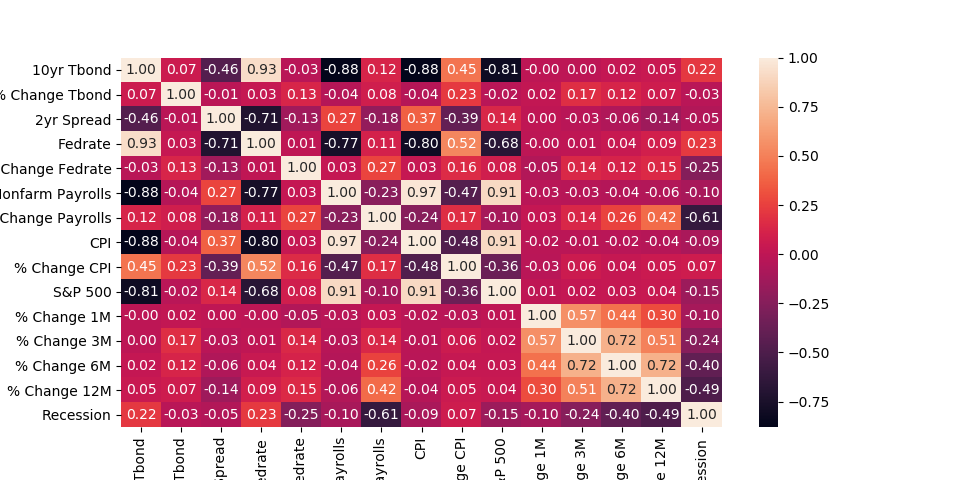

In [4]:
%matplotlib notebook
import seaborn as sns

sns.heatmap(df.corr(), annot = True, fmt = ".2f") #For feature selection use

In [5]:
#Create dataframe and dataset from selected features
data = pd.concat([tbond_10yr, spread_2yr, fedrate, nonfarm_payrolls_pchange, cpi, snp_500['12 Months'], snp_500['Recession']], axis = 1, join = 'inner')
data.columns = ['10yr Tbond', '2yr Spread', 'Fedrate', '% Change Payrolls', 'CPI', '% Change 12M', 'Recession']
data.to_csv('Project Dataset.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 1976-06-01 to 2020-02-01
Freq: MS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   10yr Tbond         525 non-null    float64
 1   2yr Spread         525 non-null    float64
 2   Fedrate            525 non-null    float64
 3   % Change Payrolls  525 non-null    float64
 4   CPI                525 non-null    float64
 5   % Change 12M       525 non-null    float64
 6   Recession          525 non-null    float64
dtypes: float64(7)
memory usage: 32.8 KB


In [7]:
data['Recession'].value_counts()

0.0    464
1.0     61
Name: Recession, dtype: int64

In [8]:
data.iloc[:, :-1].describe() #No need to include the Recession lables

,10yr Tbond,2yr Spread,Fedrate,% Change Payrolls,CPI,% Change 12M
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,6.197905,0.933276,4.907562,0.001248,162.925189,0.079103
std,3.247845,0.914207,4.036990,0.001882,57.131663,0.152295
min,1.500000,-2.130000,0.070000,-0.006001,56.700000,-0.593415
25%,3.580000,0.240000,1.340000,0.000472,113.000000,0.013773
50%,5.810000,0.870000,4.990000,0.001392,162.200000,0.102509
75%,8.210000,1.600000,6.910000,0.002256,215.445000,0.172739
max,15.320000,2.830000,19.100000,0.012404,259.050000,0.424890


<IPython.core.display.Javascript object>


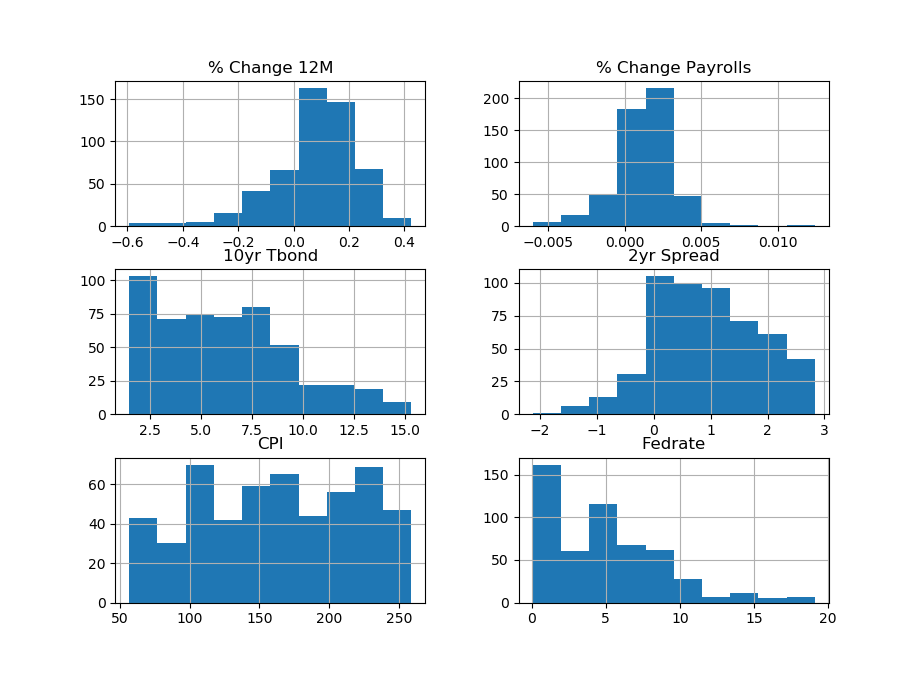

In [9]:
import matplotlib.pyplot as plt

data.iloc[:, :-1].hist()
plt.show()

<IPython.core.display.Javascript object>


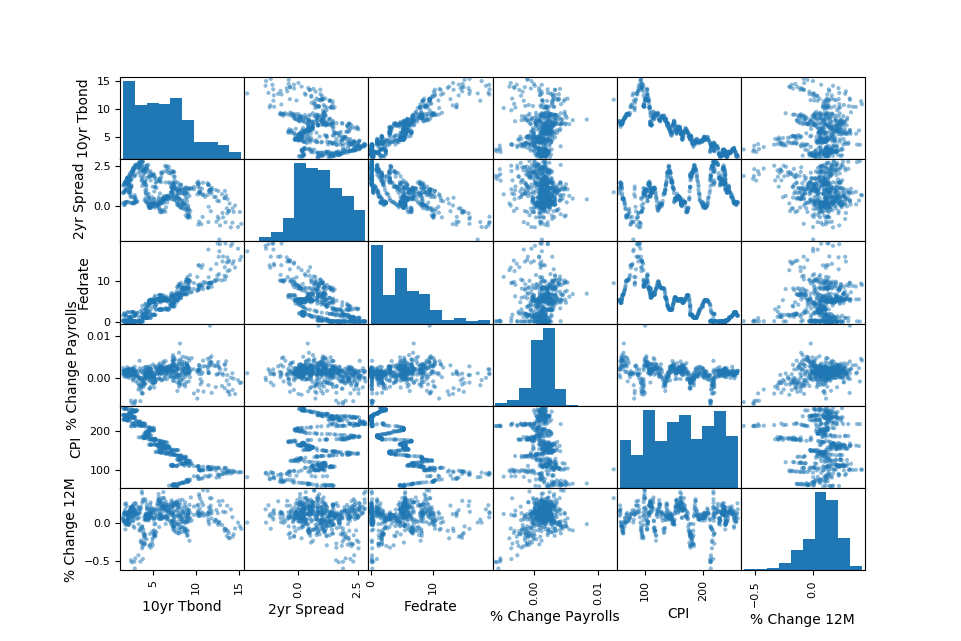

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002389879EFC8>,
      dtype=object)

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix(data.iloc[:, :-1])

In [11]:
#Train and test split using a split method specificlly for time series
from sklearn.model_selection import TimeSeriesSplit

X = data.iloc[:, 0:-1]
y = data.loc[:, 'Recession']

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]